# Helicopter prison breaks 

In this project, I scrape helicopter prison break attempts from a table on <a href = 'https://en.wikipedia.org/wiki/List_of_helicopter_prison_escapes'>wikipedia</a> using `requests` library. I then use BeautifulSoup to extract data, clean some of the columns using regular pattern (`regex`).  

I use the data to answer the following questions:
- which country has had the most helicopter escape attempts
- which decade had the most helicopter escape attempts and what is the trend with time?
- Is there a relationship between the number of escapees and whether the attempt was successful or not?


The wikipedia table is available in six columns:
- date  
    The date column is available as `August 19, 1971` and `August, 1971`. I use regex library to extract the month and year
- Prison name
- Country
- Succeeded
- Escapee(s)  
    The list of escapees is seperated by a blank line. I use a seperate function to extract the list of escapees from this column.
- Details

## Import libraries

In [1]:
from bs4 import BeautifulSoup
import requests
import time
import pandas as pd
import numpy as np
import datetime as dt
import os
import sys
import re
import matplotlib.pyplot as plt
import seaborn as sns

## define functions to scrape and clean data

In [2]:
#  define a function to obtain html
def get_html(url, sleep=5, retries=3):
    '''get html from the site'''
    html = None
    for i in range(1, retries+1):
        time.sleep(sleep * i)
        try:
            with requests.get(url) as response:
                if response.status_code == 200:
                    html = response.content
        except:
            print(sys.exc_info()[0], ' occurred.')
            continue
    
    return html

In [3]:
def scrape_table(url, sleep=5, retries=3):
    '''get html, extract the table of interest and save it to file as html'''
    content = get_html(url, sleep=5, retries=3)
    
    soup = BeautifulSoup(content, 'html.parser')
    table = None
    try:
        table = soup.find("table", class_='wikitable sortable')
    except:
        print(sys.exc_info()[0], ' occurred.')
    
    # save the html to file if it does not exist
    save_path = './prison_breaks_table.html'
    if not os.path.exists(save_path):
        if table:
            with open(save_path,'w+') as f:
                f.write(str(table))

In [4]:
# clean the column data
def clean_table_first_attempt(table):
    data = []
    for tr in table.find_all('tr'):
        tr_data = []
        for td in tr.find_all('td'):
            tr_data.append(td.get_text(strip = True))
        data.append(tr_data)
    data = data[1:]
    
    return data

def clean_escapees_column(table):

    # extract escapees: there is blank line seperating escapees
    # not properly scraped in the preceeding section of code
    escapees = []
    for tr in table.find_all('tr')[1:]:
        td_data = '' # initialise the escapees string
        row_data = tr.find_all('td')[4] # get the escapees in column index 4 
        for item in row_data.children:
            item = item.get_text(strip = True)
            if len(item) > 2:
                td_data += ',' # split each escapee with a ','
                td_data += item
        td_data = td_data.strip(',') # remove the ',' at the end of the string of scraped escapees
        escapees.append(td_data)
    return escapees

In [5]:
def retun_mmyy(text):
    mm_pattern = r'([A-Z]+)' # month as full name
    yy_pattern = r'([\d]{4})' # year as 4 digit
    mm = re.findall(mm_pattern,text,flags=re.IGNORECASE)
    yy = re.findall(yy_pattern,text)
    mm_yy = mm[0] + '-' + yy[0]
    return mm_yy

In [6]:
url = 'https://en.wikipedia.org/wiki/List_of_helicopter_prison_escapes'
# scrape and save table to file
scrape_table(url, sleep=5, retries=3)

In [7]:
table_html_path = './prison_breaks_table.html'
with open(table_html_path, 'r') as f:
    table = BeautifulSoup(f, 'html.parser')

# clean the table column headers
table_header = [header.text.strip('\n ') for header in table.find_all('th')]
data = clean_table_first_attempt(table) # first attempt clean table
escapees = clean_escapees_column(table) # clean escapees

df = pd.DataFrame(data, columns = table_header)
df['Escapee(s)'] = escapees
# turn string mm-yyyy into pd.period format
df['mm_yy'] = df['Date'].apply(retun_mmyy)
df['mm_yy'] = df['mm_yy'].apply(lambda x: dt.datetime.strptime(x,format('%B-%Y')))
df['mm_yy'] = df['mm_yy'].dt.to_period('M')
df.head()

,Date,Prison name,Country,Succeeded,Escapee(s),Details,mm_yy
0,"August 19, 1971",Santa Martha Acatitla,Mexico,Yes,"Joel David Kaplan,Carlos Antonio Contreras Castro",Joel David Kaplan was aNew Yorkbusinessman who...,1971-08
1,"October 31, 1973",Mountjoy Jail,Ireland,Yes,"JB O'Hagan,Seamus TwomeyKevin Mallon","On October 31, 1973 anIRAmember hijacked a hel...",1973-10
2,"May 24, 1978","United States Penitentiary, Marion",United States,No,"Garrett Brock Trapnell,Martin Joseph McNally,J...",43-year-old Barbara Ann Oswald hijacked aSaint...,1978-05
3,"February 27, 1981","Fleury-Mérogis, Essonne, Ile de France",France,Yes,"Gérard Dupré,Daniel Beaumont","With the help of Serge Coutel, Gérard Dupré an...",1981-02
4,"May 7, 1981","Orsainville Prison, Quebec City",Canada,No,"Marina Paquet (hijacker),Giles Arseneault (pri...",Marina Paquet held a sawed off shotgun against...,1981-05


## Which country has had the most helicopter prison breaks

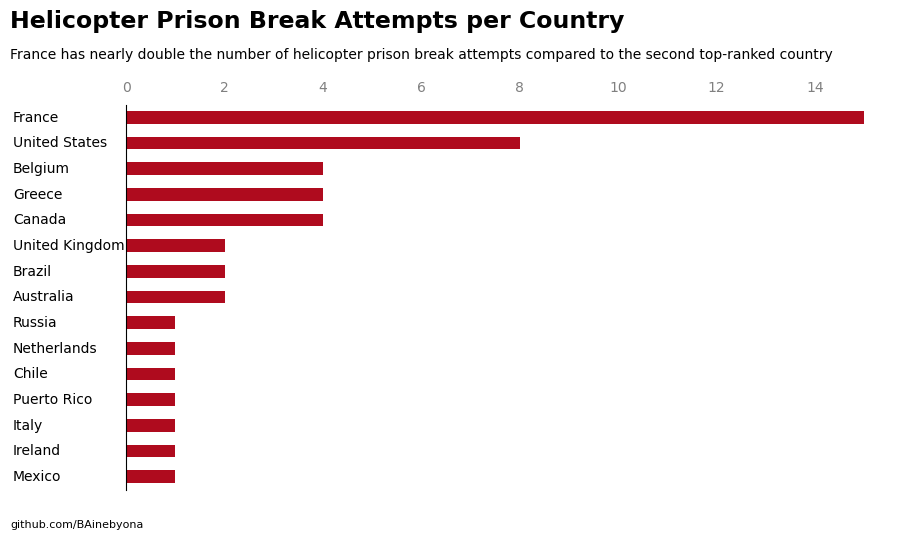

In [8]:
country_prison_breaks = df['Country'].value_counts()
fig, ax = plt.subplots(figsize=(10,5))
country_prison_breaks.sort_values(ascending = True).plot.barh(ax = ax, color='#af0b1e')
for location in ['right', 'top', 'bottom']:
    ax.spines[location].set_visible(False)
ax.set_xticks(range(0,16,2))
ax.xaxis.tick_top()
ax.tick_params(bottom=False, top=False, left=False)
ax.tick_params(axis='x', colors='grey')
ax.text(
    -0.15,
    1.2,
    'Helicopter Prison Break Attempts per Country',
    horizontalalignment="left",
    fontdict={"fontweight": "bold",'size':17},
    transform=ax.transAxes
)
ax.text(
    -0.15,
    1.12,
    'France has nearly double the number of helicopter prison break attempts compared to the second top-ranked country',
    horizontalalignment="left",
    fontdict={'size':10},
    transform=ax.transAxes
)
ax.text(-0.15, -0.1, 'github.com/BAinebyona',
       fontsize = 8,
        transform=ax.transAxes
           )
ax.set_yticklabels([]) # an empty list removes the labels
country_names = country_prison_breaks.sort_values(ascending = True).index
for i, country in zip(range(len(country_names)), country_names):
    ax.text(x=-2.3, y=i-0.15, s=country, horizontalalignment="left")

plt.show()

## which decade had the most prison break attempts

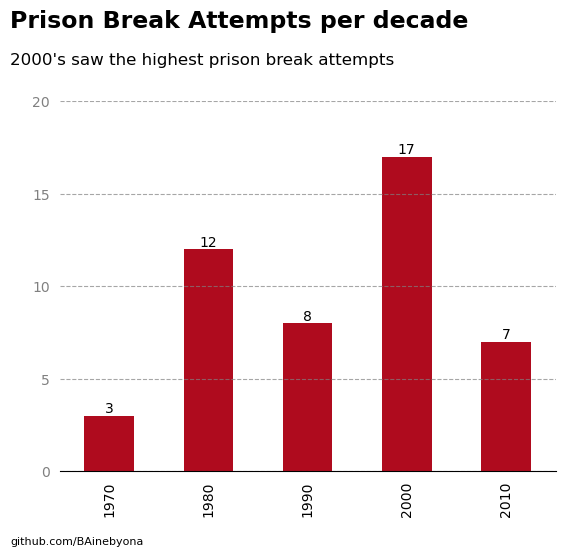

In [9]:
prison_break_decades = df['mm_yy'].to_frame()
prison_break_decades['decade'] = prison_break_decades['mm_yy'].apply(lambda x: (x.year//10)*10)
prison_break_decades = prison_break_decades['decade'].value_counts(sort = False)
prison_break_decades = prison_break_decades.iloc[:-1] # exclude 2020 decade
fig,ax = plt.subplots()
prison_break_decades.plot.bar(ax = ax, color='#af0b1e')
for location in ['right', 'top', 'left']:
    ax.spines[location].set_visible(False)
ax.tick_params(bottom=False,left = False)
ax.set(yticks = range(0,25,5),yticklabels=range(0,25,5))
ax.tick_params(axis='y', colors='grey')
labels = prison_break_decades.values
rects = ax.patches
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, height, label, ha="center", va="bottom"
    )
ax.yaxis.grid(color='gray', linestyle='dashed', alpha=0.7)
ax.text(
    -0.1,
    1.2,
    'Prison Break Attempts per decade',
    horizontalalignment="left",
    fontdict={"fontweight": "bold",'size':17},
    transform=ax.transAxes
)
ax.text(
    -0.1,
    1.1,
    '2000\'s saw the highest prison break attempts',
    horizontalalignment="left",
    fontdict={'size':12},
    transform=ax.transAxes
)
ax.text(-0.1, -0.2, 'github.com/BAinebyona',
       fontsize = 8,
        transform=ax.transAxes
           )
plt.show()

## Is there correlation between Successful prison break attempt and the number of escapees

In [10]:
escapees_per_attempt = df[['Escapee(s)','Succeeded']].copy()
# count names of escapees. if empty string, np.nan
escapees_per_attempt['#escapees'] = df['Escapee(s)'].apply(lambda x: len(x.split(',')) if len(x) >2 else np.nan)
# drop the rows where number of escapees is missing
escapees_per_attempt.dropna(subset = ['#escapees'],inplace=True)
pd.set_option("display.precision", 1)
summary_stats = escapees_per_attempt[['#escapees','Succeeded']].groupby('Succeeded').describe()
summary_stats = summary_stats['#escapees']
summary_stats.T

Succeeded,No,Yes
count,10.0,31.0
mean,1.4,2.0
std,0.7,0.9
min,1.0,1.0
25%,1.0,1.0
50%,1.0,2.0
75%,1.8,2.5
max,3.0,5.0


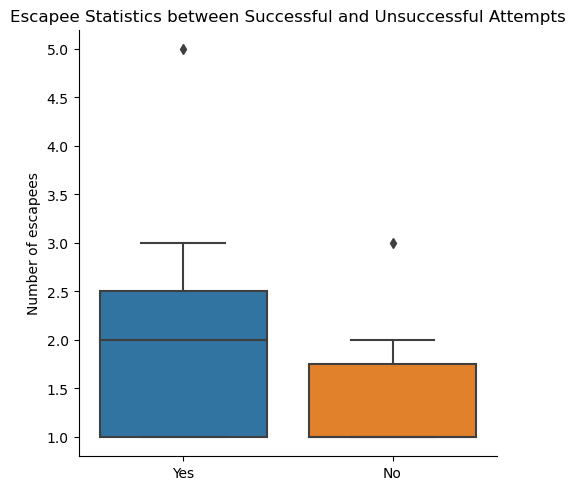

In [11]:
sns.catplot(data=escapees_per_attempt,x = 'Succeeded',y='#escapees',kind='box')
plt.title('Escapee Statistics between Successful and Unsuccessful Attempts')
plt.ylabel('Number of escapees')
plt.xlabel('')
plt.show()

## References

1. List of helicopter prison escapes. <a href = 'https://en.wikipedia.org/wiki/List_of_helicopter_prison_escapes'>Wikipedia</a>. October, 2022. Retrieved November 23, 2022.